<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/ForensicGAN/blob/main/Lhri_Thy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy-stl
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 7.0 MB/s eta 0:00:00


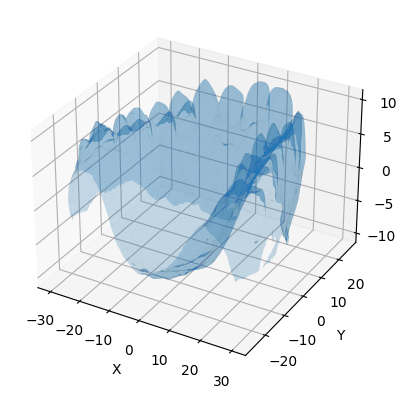

In [ ]:
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load STL file
mesh_file = '/content/drive/Shareddrives/3D/3Ddataset/target_smpl/6.stl'
my_mesh = mesh.Mesh.from_file(mesh_file)

# Extract vertices and faces
vertices = my_mesh.vectors.reshape(-1, 3)
faces = np.arange(vertices.shape[0]).reshape(-1, 3)

# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a Poly3DCollection from the faces
poly3d = [Poly3DCollection([vertices[face] for face in faces], alpha=0.25)]
ax.add_collection3d(poly3d[0])  # Pass the first element of the list

# Set plot limits and labels
ax.set_xlim([np.min(vertices[:, 0]), np.max(vertices[:, 0])])
ax.set_ylim([np.min(vertices[:, 1]), np.max(vertices[:, 1])])
ax.set_zlim([np.min(vertices[:, 2]), np.max(vertices[:, 2])])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
import os
import torch
import numpy as np
from stl import mesh
import trimesh

# Step 1: Load STL files and convert to mesh format
input_stl_folder = "/content/drive/Shareddrives/3D/3Ddataset/input_smpl"
output_stl_folder = "/content/drive/Shareddrives/3D/3Ddataset/target_smpl"
mesh_folder = "/content/drive/Shareddrives/3D/3Ddataset/mesh"

os.makedirs(mesh_folder, exist_ok=True)

for filename in os.listdir(input_stl_folder):
    if filename.endswith(".stl"):
        stl_path = os.path.join(input_stl_folder, filename)
        output_stl_path = os.path.join(output_stl_folder, filename)

        # You might want to preprocess the STL file here if needed

        mesh = trimesh.load(stl_path)
        #mesh = mesh.Mesh.from_file(stl_path)
        #vertices = input_mesh.vectors.reshape(-1, 3)
        mesh.export(os.path.join(mesh_folder, f"{filename[:-4]}.obj"), file_type="obj")

# Step 2: Normalize and preprocess the data
def normalize_mesh(mesh):
    # Perform normalization operations here
    pass

input_meshes = []
output_meshes = []

def normalize_mesh(mesh):
    # Get the vertex positions
    vertices = mesh.vertices.reshape(-1, 3)


    # Calculate the mean and standard deviation of vertex positions
    mean = np.mean(vertices, axis=0)
    std = np.std(vertices, axis=0)

    # Normalize the vertex positions to have zero mean and unit variance
    normalized_vertices = (vertices - mean) / std

    # Optionally, scale the normalized vertices to a certain range
    min_range = -1.0
    max_range = 1.0
    scaled_vertices = min_range + (normalized_vertices + 1) * (max_range - min_range) / 2.0

    # Update the mesh with the normalized vertex positions
    normalized_mesh = mesh.copy()
    normalized_mesh.vertices = scaled_vertices

    return normalized_mesh


for filename in os.listdir(mesh_folder):
    if filename.endswith(".obj"):
        obj_path = os.path.join(mesh_folder, filename)
        mesh = trimesh.load(obj_path)

        # Normalize the mesh if needed
        normalized_mesh = normalize_mesh(mesh)

        # Convert the normalized mesh to a suitable format for neural network training
        input_meshes.append(normalized_mesh.vertices)  # Example: using vertex positions as input
        output_meshes.append(normalized_mesh.vertices)  # Example: using vertex positions as output

# Convert the lists of meshes to numpy arrays
input_meshes_array = np.asarray(input_meshes, dtype=object)
#input_meshes_array = np.asarray(input_meshes.list)

output_meshes_array = np.asarray(output_meshes, dtype=object)
#output_meshes_array = np.asarray(output_meshes.list)

# Split the data into train and validation sets
train_ratio = 0.8
train_size = int(train_ratio * len(input_meshes_array))
train_input = input_meshes_array[:train_size]
train_output = output_meshes_array[:train_size]
val_input = input_meshes_array[train_size:]
val_output = output_meshes_array[train_size:]



# You can further preprocess the data as needed, like converting to voxel grids or point clouds

# Now, your train_input, train_output, val_input, and val_output are ready for training


In [ ]:
from torch.utils.data import Dataset
import torch
from stl import mesh
import os

class STLPairDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.input_dir = os.path.join(root_dir, 'input_smpl')
        self.output_dir = os.path.join(root_dir, 'target_smpl')
        self.file_list = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        input_file = os.path.join(self.input_dir, self.file_list[idx])
        output_file = os.path.join(self.output_dir, self.file_list[idx])

        input_mesh = mesh.Mesh.from_file(input_file)
        input_vertices = input_mesh.vectors.reshape(-1, 3)

        output_mesh = mesh.Mesh.from_file(output_file)
        output_vertices = output_mesh.vectors.reshape(-1, 3)

        input_vertices_tensor = torch.tensor(input_vertices, dtype=torch.float32)
        output_vertices_tensor = torch.tensor(output_vertices, dtype=torch.float32)

      #  train_ratio = 0.8
       # train_size = int(train_ratio * len(input_vertices_tensor))
        train_input = input_vertices_tensor
        train_output = output_vertices_tensor
       # val_input = input_vertices_tensor[train_size:]
       # val_output = output_vertices_tensor[train_size:]


        return train_input, train_output


In [ ]:
from numpy import savez_compressed

MyDataset = STLPairDataset('/content/drive/Shareddrives/3D/3Ddataset')
#print('Loaded: ', src_images.shape, tar_images.shape)
filename = 'occscan.npz'
savez_compressed(filename,MyDataset )
print('Saved dataset:', filename)
#print('Loaded: ', train_input.shape, train_output.shape)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Saved dataset: occscan.npz


In [ ]:
for seq in train_input: print("train_input", (np.array(seq).shape))

train_input (166854, 3)
train_input (146225, 3)
train_input (137463, 3)
train_input (153295, 3)
train_input (129333, 3)
train_input (161725, 3)
train_input (142879, 3)
train_input (473839, 3)
train_input (104614, 3)
train_input (88550, 3)
train_input (127124, 3)
train_input (97130, 3)
train_input (110629, 3)
train_input (138343, 3)
train_input (119891, 3)
train_input (104586, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, \
    UpSampling2D, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

# Define the generator model
def generator_model():
    # Encoder blocks
    def encoder_block(inputs, units):
        x = Dense(units)(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Decoder blocks
    def decoder_block(inputs, skip_features, units):
        x = Dense(units)(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Input
    input_dim = 3  # Adjust num_channels to match your data
    inputs = Input(shape=(60,40,20))

    # Encoder
    enc1 = encoder_block(inputs, units=64)
    enc2 = encoder_block(enc1, units=128)
    enc3 = encoder_block(enc2, units=256)

    # Decoder
    dec1 = decoder_block(enc3, skip_features=enc2, units=128)
    dec2 = decoder_block(dec1, skip_features=enc1, units=64)
    outputs = Dense(3, activation="tanh")(dec2)

    model = Model(inputs, outputs, name="generator")
    return model

# Define the discriminator model
def discriminator_model():
    input_dim = 3  # Adjust num_channels to match your data
    inputs = Input(shape=(60,40,20))

    x = Dense(64)(inputs)
    x = LeakyReLU(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(1)(x)
    outputs = tf.keras.activations.sigmoid(x)

    model = Model(inputs, outputs, name="discriminator")
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from keras.optimizers import Adam

# Define the combined generator and discriminator model
class GANModel(nn.Module):
    def __init__(self, generator, discriminator):
        super(GANModel, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, input):
        # Make weights in the discriminator not trainable
        for param in self.discriminator.parameters():
            param.requires_grad = False

        # Define the source input
        in_src = input

        # Connect the source input to the generator input
        gen_out = self.generator(in_src)

        # Connect the source input and generator output to the discriminator input
        dis_out = self.discriminator(torch.cat((in_src, gen_out), dim=1))

        return dis_out, gen_out

# Create the combined GAN model
image_shape = (60,40,20)  # Adjust the image shape as needed
generator = generator_model()  # Instantiate your generator model
discriminator = discriminator_model()  # Instantiate your discriminator model

gan_model = GANModel(generator, discriminator)

# Define the optimizer
lr = 0.0002
beta1 = 0.5
optimizer = optim.Adam(gan_model.generator('/content/occscan.npz'), lr=lr, betas=(beta1, 0.999))




# Define the loss function and weights
criterion_dis = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion_gen = nn.L1Loss()   # Mean Absolute Error Loss
lambda_weight = 100  # Adjust the weight as needed

# Use the optimizer and loss function to compile the model
def compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight):
    gan_model.optimizer = optimizer
    gan_model.criterion_dis = criterion_dis
    gan_model.criterion_gen = criterion_gen
    gan_model.lambda_weight = lambda_weight

compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight)


TypeError: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam

image_shape = (60,40,20)  # Adjust the image shape as needed
generator = generator_model()  # Instantiate your generator model
discriminator = discriminator_model()  # Instantiate your discriminator model

gan_model = GANModel(generator, discriminator)

# Define the optimizer
lr = 0.0002
beta1 = 0.5
opt = Adam(lr=lr, betas=(beta1, 0.999))
model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])


# Define the loss function and weights
criterion_dis = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion_gen = nn.L1Loss()   # Mean Absolute Error Loss
lambda_weight = 100  # Adjust the weight as needed



TypeError: ignored

In [ ]:
# Use the optimizer and loss function to compile the model
def compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight):
    gan_model.optimizer = optimizer
    gan_model.criterion_dis = criterion_dis
    gan_model.criterion_gen = criterion_gen
    gan_model.lambda_weight = lambda_weight

compile_gan_model(gan_model, optimizer, criterion_dis, criterion_gen, lambda_weight)

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

def load_real_samples(filename):
    # Load compressed arrays (assuming the file is in NumPy format)
    data = np.load(filename)

    # Unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']

    # Create PyTorch tensors from the NumPy arrays
    X1_tensor = torch.tensor(X1, dtype=torch.float32)
    X2_tensor = torch.tensor(X2, dtype=torch.float32)

    # Normalize the data if necessary
    # You can apply custom preprocessing steps for 3D objects here

    # Create PyTorch datasets
    dataset = TensorDataset(X1_tensor, X2_tensor)

    return dataset


In [ ]:
import torch
import torch.nn.functional as F
import torch.utils.data as data

def generate_real_samples(dataset, n_samples, patch_shape):
    # Unpack the dataset
    trainA, trainB = dataset

    # Randomly choose indices for the selected images
    ix = torch.randint(0, trainA.shape[0], (n_samples,))

    # Retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # Generate 'real' class labels (1)
    y = torch.ones((n_samples, 1, patch_shape, patch_shape), dtype=torch.float32)

    return [X1, X2], y


In [ ]:
import torch

def generate_fake_samples(g_model, samples, patch_shape):
    # Generate fake instances using the generator model
    with torch.no_grad():
        X = g_model(samples).detach().cpu().numpy()  # Assuming g_model is a PyTorch model

    # Create 'fake' class labels (0)
    y = torch.zeros((len(X), 1, patch_shape, patch_shape), dtype=torch.float32)

    return X, y


In [ ]:
import torch
import matplotlib.pyplot as plt

def summarize_performance(step, g_model, dataset, n_samples=3):
    # Set the generator model to evaluation mode (no training)
    g_model.eval()

    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # Scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # Plot real source images, generated target images, and real target images
    fig, axes = plt.subplots(3, n_samples, figsize=(10, 8))
    for i in range(n_samples):
        axes[0, i].imshow(X_realA[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(X_fakeB[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[2, i].imshow(X_realB[i].permute(1, 2, 0))
        axes[2, i].axis('off')

    # Save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()

    # Save the generator model
    filename2 = 'model_%06d.pth' % (step+1)
    torch.save(g_model.state_dict(), filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

    # Set the generator model back to training mode
    g_model.train()


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

def train(d_model, g_model, gan_model, dataset, n_epochs=100, batch_size=1):
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # Unpack the dataset
    trainA, trainB = dataset

    # Create PyTorch DataLoader for efficient batching
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define optimizers for generator and discriminator
    g_optimizer = optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Loss functions for discriminator and generator
    criterion = nn.BCELoss()

    # Calculate the number of batches per training epoch
    bat_per_epo = len(dataloader)

    # Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # Manually enumerate epochs
    for epoch in range(n_epochs):
        for i, data in enumerate(dataloader):
            # Unpack data
            X_realA, X_realB = data

            # Create labels for real and fake data
            y_real = torch.ones((X_realA.size(0), 1, n_patch, n_patch), dtype=torch.float32)
            y_fake = torch.zeros((X_realA.size(0), 1, n_patch, n_patch), dtype=torch.float32)

            # Reset gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # Generate fake samples
            X_fakeB, _ = generate_fake_samples(g_model, X_realA, n_patch)

            # Convert images and labels to the appropriate device (CPU or GPU)
            X_realA, X_realB, y_real, y_fake = X_realA.to(device), X_realB.to(device), y_real.to(device), y_fake.to(device)
            X_fakeB = X_fakeB.to(device)

            # Discriminator update for real samples
            d_real_loss = criterion(d_model(X_realA, X_realB), y_real)

            # Discriminator update for fake samples
            d_fake_loss = criterion(d_model(X_realA, X_fakeB), y_fake)

            # Generator update
            g_loss, _, _ = gan_model(X_realA, [y_real, X_realB])
            g_loss = criterion(g_loss, y_real)

            # Backpropagation and optimization
            d_loss = 0.5 * (d_real_loss + d_fake_loss)
            d_loss.backward()
            d_optimizer.step()

            g_loss.backward()
            g_optimizer.step()

            # Summarize performance
            print('Epoch [%d/%d] Batch [%d/%d] D_Loss: %.4f G_Loss: %.4f'
                  % (epoch+1, n_epochs, i+1, bat_per_epo, d_loss.item(), g_loss.item()))

        # Summarize model performance
        if (epoch+1) % 10 == 0:
            summarize_performance(epoch, g_model, dataset)


In [ ]:
import numpy as np
import torch

# Load and preprocess the dataset
def load_real_samples(filename):
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = load_real_samples('occscan.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define the input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# Define and initialize the models
from your_model_definitions import define_discriminator, define_generator, define_gan  # Replace with actual model definitions

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

# Train the models
from your_training_function import train  # Replace with your training function

train(d_model, g_model, gan_model, dataset)


In [ ]:
import torch

# Define the generator loss
def generator_loss(disc_generated_output, gen_output, target):
    # Mean squared error loss
    mse_loss = torch.mean((target - gen_output)**2)

    # Adversarial loss (encourages generator to fool the discriminator)
    adversarial_loss = torch.mean((disc_generated_output - 1)**2)

    # Combined loss
    total_loss = mse_loss + 0.1 * adversarial_loss  # Adjust the weight as needed

    return total_loss

# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    # Adversarial loss for real data
    real_loss = torch.mean((disc_real_output - 1)**2)

    # Adversarial loss for generated data
    generated_loss = torch.mean(disc_generated_output**2)

    # Combined loss
    total_loss = real_loss + generated_loss

    return total_loss


In [ ]:
import os
import torch
import torch.optim as optim
#from your_generator_and_discriminator_modules import generator_model, discriminator_model  # Import your generator and discriminator models

# Define optimizers
learning_rate = 0.0002
beta1 = 0.5  # Similar to beta_1 in Adam optimizer for TensorFlow

generator_optimizer = optim.Adam(generator_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Define the generator and discriminator models
generator = generator_model()
discriminator = discriminator_model()

# Define checkpointing
checkpoint_dir = "./checkpoints"  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a dictionary of models and optimizers for checkpointing
checkpoint_dict = {
    'generator_optimizer': generator_optimizer.state_dict(),
    'discriminator_optimizer': discriminator_optimizer.state_dict(),
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
}

# Save the checkpoint
torch.save(checkpoint_dict, checkpoint_prefix)


NameError: ignored

In [ ]:
import torch.optim as optim

lr = 0.0002  # Learning rate
beta1 = 0.5  # Adam optimizer beta1

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
import os
from torch.utils.data import DataLoader

dataset = STLPairDataset(root_dir='/content/drive/Shareddrives/3D/3Ddataset')
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)


In [ ]:
import os
import numpy as np
import trimesh

# Step 1: Load STL files and convert to mesh format
input_stl_folder = "/content/drive/Shareddrives/3D/3Ddataset/input_smpl"
output_stl_folder = "/content/drive/Shareddrives/3D/3Ddataset/target_smpl"
mesh_folder = "/content/drive/Shareddrives/3D/3Ddataset/mesh"

os.makedirs(mesh_folder, exist_ok=True)

for filename in os.listdir(input_stl_folder):
    if filename.endswith(".stl"):
        stl_path = os.path.join(input_stl_folder, filename)
        output_stl_path = os.path.join(output_stl_folder, filename)

        # You might want to preprocess the STL file here if needed

        mesh = trimesh.load(stl_path)
        mesh.export(os.path.join(mesh_folder, f"{filename[:-4]}.obj"), file_type="obj")

# Step 2: Normalize and preprocess the data
def normalize_mesh(mesh):
    # Perform normalization operations here
    pass

input_meshes = []
output_meshes = []

def normalize_mesh(mesh):
    # Get the vertex positions
    #vertices = mesh.vertices
    vertices = my_mesh.vectors.reshape(-1, 3)
    faces = np.arange(vertices.shape[0]).reshape(-1, 3)

    # Calculate the mean and standard deviation of vertex positions
    mean = np.mean(vertices, axis=0)
    std = np.std(vertices, axis=0)

    # Normalize the vertex positions to have zero mean and unit variance
    normalized_vertices = (vertices - mean) / std

    # Optionally, scale the normalized vertices to a certain range
    min_range = -1.0
    max_range = 1.0
    scaled_vertices = min_range + (normalized_vertices + 1) * (max_range - min_range) / 2.0

    # Update the mesh with the normalized vertex positions
    normalized_mesh = mesh.copy()
    normalized_mesh.vertices = scaled_vertices

    return normalized_mesh


for filename in os.listdir(mesh_folder):
    if filename.endswith(".obj"):
        obj_path = os.path.join(mesh_folder, filename)
        mesh = trimesh.load(obj_path)

        # Normalize the mesh if needed
        normalized_mesh = normalize_mesh(mesh)

        # Convert the normalized mesh to a suitable format for neural network training
        input_meshes.append(normalized_mesh.vertices)  # Example: using vertex positions as input
        output_meshes.append(normalized_mesh.vertices)  # Example: using vertex positions as output

# Convert the lists of meshes to numpy arrays
input_meshes_array = np.asarray(input_meshes, dtype=list)
output_meshes_array = np.asarray(output_meshes, dtype=list)

# Split the data into train and validation sets
train_ratio = 0.8
train_size = int(train_ratio * len(input_meshes_array))
train_input = input_meshes_array[:train_size]
train_output = output_meshes_array[:train_size]
val_input = input_meshes_array[train_size:]
val_output = output_meshes_array[train_size:]

# You can further preprocess the data as needed, like converting to voxel grids or point clouds

# Now, your train_input, train_output, val_input, and val_output are ready for training


In [ ]:
from numpy import savez_compressed

filename = 'occscan.npz'
savez_compressed(filename, train_input, train_output)
print('Saved dataset:', filename)
print('Loaded: ', train_input.shape, train_output.shape)

NameError: ignored

In [ ]:
print(train_output)

NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, \
    UpSampling3D, Concatenate, LeakyReLU

# Define the generator model
def generator_model():
    # Encoder blocks
    def encoder_block(inputs, filters, kernel_size, strides):
        x = Conv3D(filters, kernel_size, strides=strides, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Decoder blocks
    def decoder_block(inputs, skip_features, filters, kernel_size, strides):
        x = UpSampling3D(size=strides)(inputs)
        x = Concatenate()([x, skip_features])
        x = Conv3D(filters, kernel_size, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Input
    inputs = Input(shape=(None, None, None, 3))  # Adjust num_channels to match your data

    # Encoder
    enc1 = encoder_block(inputs, filters=64, kernel_size=3, strides=1)
    enc2 = encoder_block(enc1, filters=128, kernel_size=3, strides=2)
    enc3 = encoder_block(enc2, filters=256, kernel_size=3, strides=2)

    # Decoder
    dec1 = decoder_block(enc3, skip_features=enc2, filters=128, kernel_size=3, strides=2)
    dec2 = decoder_block(dec1, skip_features=enc1, filters=64, kernel_size=3, strides=2)
    outputs = Conv3D(4, kernel_size=1, activation="tanh", padding="same")(dec2)

    model = tf.keras.Model(inputs, outputs, name="generator")
    return model

# Define the discriminator model
def discriminator_model():
    inputs = Input(shape=(None, None, None, 3))  # Adjust num_channels to match your data

    x = Conv3D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv3D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv3D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv3D(512, kernel_size=4, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv3D(1, kernel_size=4, strides=1, padding="same")(x)
    outputs = tf.keras.activations.sigmoid(x)

    model = tf.keras.Model(inputs, outputs, name="discriminator")
    return model


SyntaxError: ignored

In [ ]:
import tensorflow as tf

# Define the generator loss
def generator_loss(disc_generated_output, gen_output, target):
    # Mean squared error loss
    mse_loss = tf.reduce_mean(tf.square(target - gen_output))

    # Adversarial loss (encourages generator to fool the discriminator)
    adversarial_loss = tf.reduce_mean(tf.square(disc_generated_output - 1))

    # Combined loss
    total_loss = mse_loss + 0.1 * adversarial_loss  # Adjust the weight as needed

    return total_loss

# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    # Adversarial loss for real data
    real_loss = tf.reduce_mean(tf.square(disc_real_output - 1))

    # Adversarial loss for generated data
    generated_loss = tf.reduce_mean(tf.square(disc_generated_output))

    # Combined loss
    total_loss = real_loss + generated_loss

    return total_loss


In [ ]:
import os
import tensorflow as tf

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define the generator and discriminator models
generator = generator_model()
discriminator = discriminator_model()

# Define checkpointing
checkpoint_dir = "./checkpoints"  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
import os
import torch
import torch.optim as optim
from your_generator_and_discriminator_modules import generator_model, discriminator_model  # Import your generator and discriminator models

# Define optimizers
learning_rate = 0.0002
beta1 = 0.5  # Similar to beta_1 in Adam optimizer for TensorFlow

generator_optimizer = optim.Adam(generator_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Define the generator and discriminator models
generator = generator_model()
discriminator = discriminator_model()

# Define checkpointing
checkpoint_dir = "./checkpoints"  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a dictionary of models and optimizers for checkpointing
checkpoint_dict = {
    'generator_optimizer': generator_optimizer.state_dict(),
    'discriminator_optimizer': discriminator_optimizer.state_dict(),
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
}

# Save the checkpoint
torch.save(checkpoint_dict, checkpoint_prefix)


In [ ]:
import torch.optim as optim

lr = 0.0002  # Learning rate
beta1 = 0.5  # Adam optimizer beta1

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


AttributeError: ignored

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    for real_data in dataloader:
        # Train discriminator on real data
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        real_output = discriminator(real_data)
        loss_real = criterion(real_output, real_labels)
        loss_real.backward()

        # Train discriminator on fake data
        fake_labels = torch.zeros(batch_size, 1)
        z = torch.randn(batch_size, noise_dim)
        fake_data = generator(z)
        fake_output = discriminator(fake_data.detach())
        loss_fake = criterion(fake_output, fake_labels)
        loss_fake.backward()

        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        z = torch.randn(batch_size, noise_dim)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        loss_gen = criterion(fake_output, real_labels)
        loss_gen.backward()

        optimizer_g.step()


NameError: ignored

In [ ]:
[print(i.shape, i.dtype) for i in generator.inputs]
[print(o.shape, o.dtype) for o in generator.outputs]
[print(l.name, l.input_shape, l.dtype) for l in generator.layers]

In [ ]:
# Define the number of epochs and steps per epoch
num_epochs = 100
batch_size = 4
steps_per_epoch = len(train_input) // batch_size

# Training loop
for epoch in range(num_epochs):
    for step in range(steps_per_epoch):
        # Select a random batch of training data
        batch_indices = np.random.randint(0, len(train_input), size=batch_size)
        real_batch_input = train_input[batch_indices]
        real_batch_output = train_output[batch_indices]

        # Generate fake data using the generator
        fake_batch_output = generator(real_batch_input, training=True)

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            disc_real_output = discriminator([real_batch_input, real_batch_output], training=True)
            disc_fake_output = discriminator([real_batch_input, fake_batch_output], training=True)

            disc_loss_real = discriminator_loss(disc_real_output)
            disc_loss_fake = discriminator_loss(disc_fake_output)
            total_disc_loss = disc_loss_real + disc_loss_fake

        disc_gradients = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            gen_output = generator(real_batch_input, training=True)
            disc_fake_output = discriminator([real_batch_input, gen_output], training=True)

            gen_loss = generator_loss(disc_fake_output, gen_output, real_batch_output)

        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

    # Print and save progress
    print(f"Epoch {epoch+1}/{num_epochs}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {total_disc_loss:.4f}")

    # Save checkpoint at the end of each epoch
    checkpoint.save(file_prefix=checkpoint_prefix)


ValueError: ignored

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from keras.models import Model
#from keras.models import Input
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('occscan.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed ararys
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
...
# load dataset
[X1, X2] = load_real_samples('occscan.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (27, 256, 256, 3) (27, 256, 256, 3)


In [ ]:
...
# load model
model = load_model('model_109600.h5')

NameError: ignored

In [ ]:
...
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [ ]:
...
# generate image from source
gen_image = model.predict(src_image)

In [ ]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
...
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (27, 256, 256, 3) (27, 256, 256, 3)


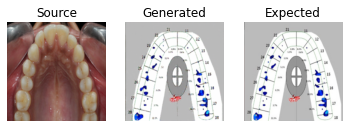

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_109600.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [ ]:
import tensorflow as tf
import torch
import pymesh

# Define the generator and discriminator networks
def generator_model():
    # Implement your generator architecture (e.g., a deep convolutional neural network)
    pass

def discriminator_model():
    # Implement your discriminator architecture (e.g., a deep convolutional neural network)
    pass

# Define loss functions
def generator_loss(fake_output):
    # Implement the generator loss function (e.g., binary cross-entropy)
    pass

def discriminator_loss(real_output, fake_output):
    # Implement the discriminator loss function (e.g., binary cross-entropy)
    pass

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define training loop
@tf.function
def train_step(images):
    # Generate a batch of random noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake 3D objects using the generator
        generated_images = generator(noise, training=True)

        # Get discriminator's predictions for real and fake objects
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients and update generator and discriminator weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Load 3D STL images and convert to mesh format (using PyMesh)
def load_and_convert_stl_to_mesh(file_path):
    # Load STL file using PyMesh
    mesh = pymesh.load_mesh(file_path)

    # Perform any necessary preprocessing or conversions on the mesh
    # (e.g., normalization, simplification, etc.)

    return mesh

# Main training loop
EPOCHS = 10000  # Adjust as needed
BATCH_SIZE = 64  # Adjust as needed
NOISE_DIM = 100  # Dimension of the input noise vector

for epoch in range(EPOCHS):
    for batch in dataset:  # Replace 'dataset' with your data loading logic
        images = load_and_convert_stl_to_mesh(batch)  # Load and convert STL to mesh

        # Train the GAN
        train_step(images)

    # Save generated 3D objects or checkpoint models periodically
    if (epoch + 1) % 100 == 0:
        generator.save('generator_model.h5')
        discriminator.save('discriminator_model.h5')
